# Import TensorFlow and other libraries

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [9]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Download and explore the dataset


In [10]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

f = open("failed.txt","w+")
folder_id = '....'
os.mkdir('data')
root = './data/raw'
os.mkdir(root)

def escape_fname(name):
    return name.replace('/','_')

def search_folder(folder_id, root):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    for file in file_list:
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            prod_cat_foldername = file['title'].split('_')[0]
            prod_cat_folder = create_folder(root, prod_cat_foldername)
            class_foldername = escape_fname(file['title'])
            class_folder = create_folder(prod_cat_folder+'/', class_foldername)
            search_folder(file['id'], class_folder)
        else:
            # download_mimetype = None
            filename = escape_fname(file['title'])
            filename = '{}{}'.format(root+'/', filename)
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def create_folder(path,name):
    folder = '{}{}'.format(path,escape_fname(name))
    if not os.path.isdir(folder):
      print(f"Creating folder: {folder}")
      os.mkdir(folder)
    return folder

search_folder(folder_id,root+'/')
f.close()

Creating folder: ./data/raw/clothes
Creating folder: ./data/raw/clothes/clothes_0_model_front
Creating folder: ./data/raw/clothes/clothes_2_model_back
Creating folder: ./data/raw/clothes/clothes_4_look
Creating folder: ./data/raw/clothes/clothes_1_zoomed
Creating folder: ./data/raw/clothes/clothes_3_ghost


In [28]:
import pathlib

# dataset_url = "https://drive.google.com/file/d/1wTosLD8TJafup3BFWbvPUsSrktXeeE7K/view?usp=sharing"
# data_dir = tf.keras.utils.get_file('image_data', origin=dataset_url, untar=True)
# data_dir = pathlib.Path(dataset_url)

# orig_url = "https://drive.google.com/drive/folders/1OGAwpSWHQgvqQJRndXDudDfZH0tZ1Wu9?usp=drive_link" # for indivisual file download
# file_id = orig_url.split('/')[-2]
# dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
# data_dir = pathlib.Path(dwn_url)


# data_dir = root
data_dir = './data/raw/clothes'
data_dir = pathlib.Path(data_dir)


In [29]:
data_dir


PosixPath('data/raw/clothes')

In [4]:
# !sudo apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (82.5 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 121730 files and directories currently instal

In [5]:
#  !tree --dirsfirst --filelimit 6 '/root/.keras/datasets/image_data'

/root/.keras/datasets/image_data  [error opening dir]

0 directories, 0 files


In [26]:
# count of all images
# image_count = len(list(data_dir.glob('*/*.jpg')))
# print(image_count)

0


In [16]:
# bags = list(data_dir.glob('bag_0_front/*'))
# PIL.Image.open(str(bags[1]))

IndexError: list index out of range

# Create a dataset
- Adopted from DLG_D3_T3_CNN_training_and_transfer_learning

In [17]:
# Define some parameters for the loader:

BATCH_SIZE = 32
IMG_HEIGHT = 427
IMG_WIDTH = 350

classes = ['clothes_0_model_front', 'clothes_1_zoomed', 'clothes_2_model_back', 'clothes_3_ghost', 'clothes_4_look']

In [64]:
# 70% of the images are used for training, and 30% for validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.7,
  subset="training",
  seed=42,
  class_names=classes,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=42,
  class_names=classes,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 1271 files belonging to 5 classes.
Using 382 files for training.
Found 1271 files belonging to 5 classes.
Using 381 files for validation.


In [31]:
class_names = train_ds.class_names
print(class_names)

['clothes_0_model_front', 'clothes_1_zoomed', 'clothes_2_model_back', 'clothes_3_ghost', 'clothes_4_look']


# Standardize the data

In [32]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

# Create the model

In [65]:
num_classes = 5

model = Sequential([

  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # Standardize the data

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(256, activation='relu'),

  layers.Dense(num_classes, activation='softmax')

])

# Compile the model

In [68]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Model summary

In [69]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 427, 350, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 427, 350, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 213, 175, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 213, 175, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 106, 87, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 106, 87, 64)      

# Find the defected images
- to address the following error:
    - # InvalidArgumentError'>,Invalid JPEG data or crop window
    - # jpeg::Uncompress failed. Invalid JPEG data or crop window

In [56]:
# adopted from: https://github.com/tensorflow/tpu/issues/455#issuecomment-748435374
# adopted from: https://github.com/tensorflow/tpu/issues/455#issuecomment-911746254

from struct import unpack
from tqdm import tqdm
import os

image_file = '/content/data/raw/clothes' #???_F

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()

    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]
            if len(data)==0:
               raise TypeError("issue reading jpeg file")


bads = []

# img_dir = './content/data/raw/clothes/' # ????_F
img_dir = '/content/data/raw/clothes'

# root_img = './content/data/raw/clothes'

for dirName, subdirList, fileList in os.walk(img_dir):
    imagesList = fileList
    for img in tqdm(imagesList): # tqdm is just for visualizing progress bar for "for loop". It, 'tqdm(imagesList)', may be replaced by the imagesList
      image = os.path.join(dirName,img)
      image = JPEG(image)
      try:
        image.decode()
      except:
        bads.append(dirName+'/'+img)


# for name in bads:
#   os.remove(os.path.join(dirName,name))

0it [00:00, ?it/s]
100%|██████████| 223/223 [00:00<00:00, 10648.71it/s]


In [76]:
# os.path.join(*img_dir.split('/'))  # makes the path system (OS) agnostic

In [57]:
bads # ['/content/data/raw/clothes/clothes_1_zoomed/32760559-001.jpg']

['/content/data/raw/clothes/clothes_1_zoomed/32760559-001.jpg']

In [61]:
# remove the truncated image file
for name in bads:
  os.remove(os.path.join(dirName,name))

''' after removing the defected image ('/content/data/raw/clothes/clothes_1_zoomed/32760559-001.jpg'), we need to rerun the train-validation split functions:
 (f.keras.preprocessing.image_dataset_from_directory), model creation, model compile, and model training steps
'''

In [62]:
# bads_np_arr = np.array(bads)

# # from matplotlib import pyplot as plt
# # plt.imshow(bads_np_arr, interpolation='nearest')
# # plt.show()

# image = plt.imread('/content/data/raw/clothes/clothes_1_zoomed/32760559-001.jpg')
# plt.imshow(image)

# Train the model

In [70]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
12/12 [==============================] - 95s 8s/step - loss: 7.3384 - accuracy: 0.2592 - val_loss: 0.9498 - val_accuracy: 0.6562
Epoch 2/10
12/12 [==============================] - 109s 9s/step - loss: 0.7215 - accuracy: 0.6806 - val_loss: 0.6487 - val_accuracy: 0.7139
Epoch 3/10
12/12 [==============================] - 87s 7s/step - loss: 0.3818 - accuracy: 0.8272 - val_loss: 0.6201 - val_accuracy: 0.7717
Epoch 4/10
12/12 [==============================] - 92s 8s/step - loss: 0.2054 - accuracy: 0.9241 - val_loss: 0.5184 - val_accuracy: 0.8425
Epoch 5/10
12/12 [==============================] - 87s 7s/step - loss: 0.0800 - accuracy: 0.9764 - val_loss: 0.5260 - val_accuracy: 0.8556
Epoch 6/10
12/12 [==============================] - 84s 7s/step - loss: 0.1196 - accuracy: 0.9581 - val_loss: 0.7643 - val_accuracy: 0.7769
Epoch 7/10
12/12 [==============================] - 84s 7s/step - loss: 0.1290 - accuracy: 0.9660 - val_loss: 0.7040 - val_accuracy: 0.8110
Epoch 8/10
12/12 [=

# Training results visualization

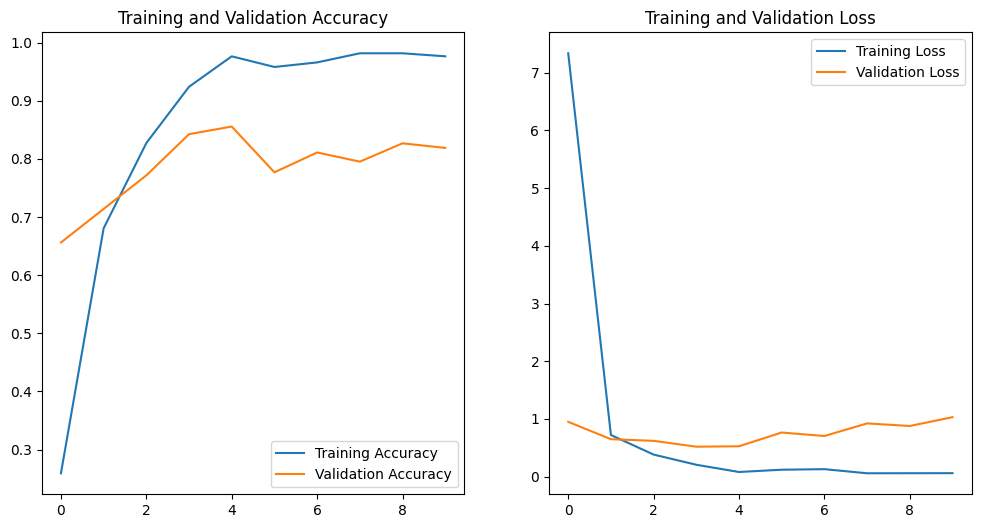

In [71]:
# Creates plots of loss and accuracy on the training and validation sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# TODO:

# dropout # DLG_D3_T3_CNN_training_and_transfer_learning
# augmentation # DLG_D3-4_E2_Transfer_Learning (day3&4-helper notebook2)
# early stopping DLG_D3_T3_CNN_training_and_transfer_learning
# model validation/ model report/ classification report/ model metrics calculation?? # Part2_Transfer_Learning_solution_D3 # Part2_Transfer_Learning_solution_Fine_Tuning_D4 # DLG_D3-4_E2_Transfer_Learning (day3&4-helper notebook2)
                                                                                      # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

# confusion matrix ??